# Gaussian Mixtures

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

The *k*-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
In particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

## Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [2]:
from sklearn.datasets import make_blobs

# Generate synthetic data
X, y_true = make_blobs(n_samples=400,       # Number of samples to generate
                       centers=4,           # Number of centers (clusters) to generate
                       cluster_std=0.60,    # Standard deviation of the clusters
                       random_state=0)      # Seed for random number generator to ensure reproducibility

# flip axes for better plotting
X = X[:, ::-1] 

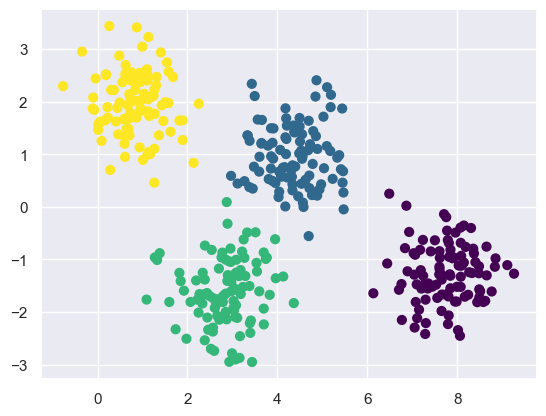

In [3]:
from sklearn.cluster import KMeans

# Initialize the KMeans model with 4 clusters and a fixed random state for reproducibility
kmeans = KMeans(4, random_state=0)

# Fit the KMeans model to the data and predict the cluster labels for each point
labels = kmeans.fit(X).predict(X)

# Plot the data points with colors corresponding to the KMeans cluster labels
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:


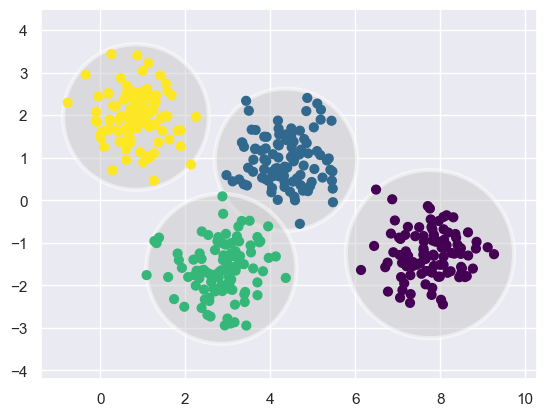

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    
    # Fit the KMeans model to the data and predict the cluster labels
    labels = kmeans.fit_predict(X)

    # Plot the input data
    ax = ax or plt.gca()  # Use the provided Axes object or create a new one
    ax.axis('equal')  # Set equal scaling for both axes
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)  # Plot data points

    # Plot the representation of the KMeans model
    centers = kmeans.cluster_centers_  # Get the cluster centers
    
    # Calculate the maximum distance from each cluster center to any point in the cluster
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        # Add a circle around each cluster center to represent the cluster radius
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

# Create and plot the KMeans model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models *must be circular*: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

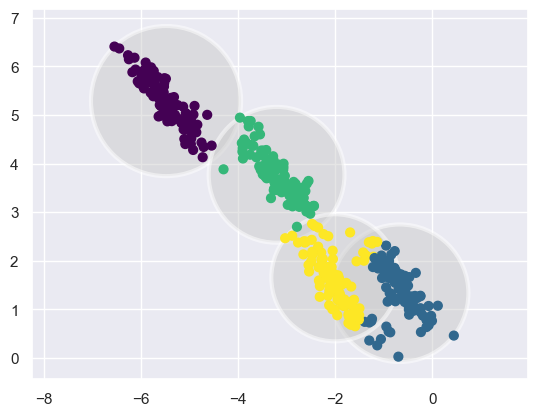

In [5]:
'''
This code modifies the original dataset `X` by applying a linear transformation, resulting in a stretched `version X_stretched`. 
It then applies KMeans clustering with 4 clusters to this transformed data and visualizes the results using the `plot_kmeans` function.
'''

# Set a random seed for reproducibility using numpy's RandomState
rng = np.random.RandomState(13)

# Stretch the original dataset by multiplying it with a random 2x2 matrix
X_stretched = np.dot(X, rng.randn(2, 2))

# Create and fit a KMeans model with 4 clusters on the stretched data
kmeans = KMeans(n_clusters=4, random_state=0)

# Plot the KMeans clustering results on the stretched data
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation by preprocessing the data with PCA, but in practice there is no guarantee that such a global operation will circularize the individual data.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

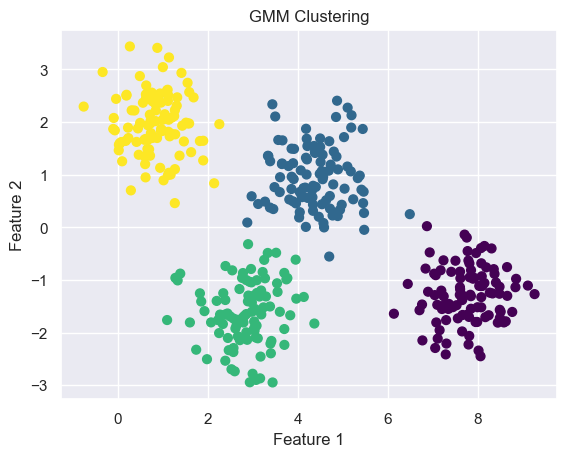

In [6]:
from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model (GMM) with 4 components
gmm = GaussianMixture(n_components=4, random_state=0)

# Fit the GMM to the data
gmm.fit(X)

# Predict the cluster labels for the data points
labels = gmm.predict(X)

# Plot the data points, colored by their predicted GMM cluster labels
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [7]:
# Calculate the probability for each point in X belonging to each of the 4 GMM components
probs = gmm.predict_proba(X)

# Print the probabilities of the first 5 data points rounded to 3 decimal places
print(probs[:5].round(3))

[[0.469 0.531 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

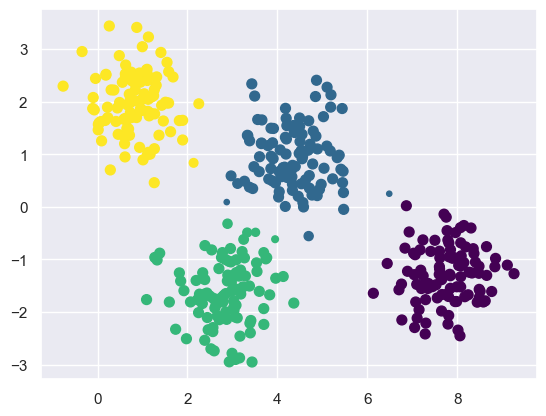

In [8]:
# Determine the size of each point based on the maximum probability of it belonging to a cluster
# The square of the maximum probability emphasizes the differences in point sizes
size = 50 * probs.max(1) ** 2

# Plot the data points, using the computed sizes and the GMM cluster labels for color
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Let's put an outline to make it easier to see the size of each point.

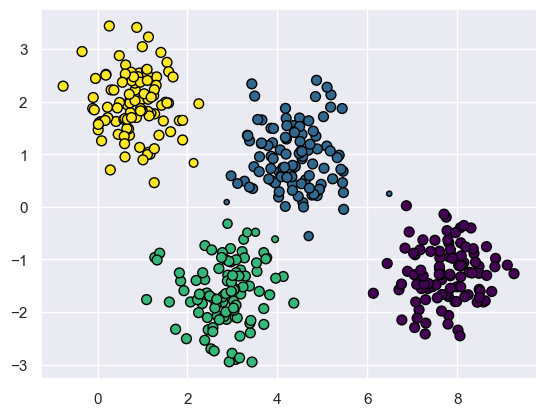

In [9]:
# Determine the size of each point based on the maximum probability of it belonging to a cluster
# The square of the maximum probability emphasizes the differences in point sizes
size = 50 * probs.max(1) ** 2

# Plot the data points, using the computed sizes and the GMM cluster labels for color
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size, edgecolor='black');

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

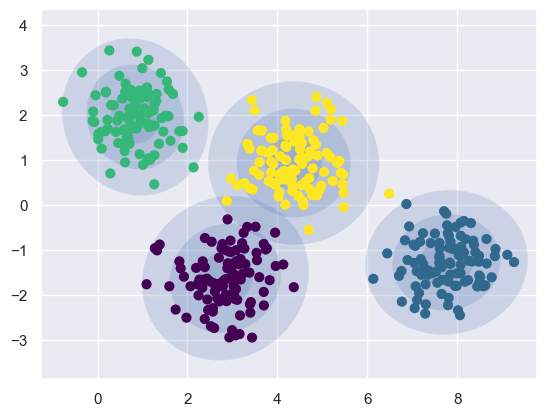

In [10]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse representing the Gaussian component.

    Parameters:
    - position: Center of the ellipse (mean of the Gaussian).
    - covariance: Covariance matrix of the Gaussian, used to determine the shape and orientation.
    - ax: Matplotlib axis object to draw on.
    - kwargs: Additional arguments for customizing the appearance of the ellipse.
    """
    ax = ax or plt.gca()  # Use provided axis or the current axis if none provided
    
    # Check if covariance matrix is 2x2 (for 2D data)
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)              # Singular Value Decomposition
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))  # Calculate rotation angle
        width, height = 2 * np.sqrt(s)                    # Calculate width and height from eigenvalues
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)           # For cases where covariance is 1D
    
    # Draw the ellipse for 1, 2, and 3 standard deviations (nsig)
    for nsig in range(1, 4):
        ell = Ellipse(position, nsig * width, nsig * height,
                      angle=angle, **kwargs)
        ax.add_patch(ell)

def plot_gmm(gmm, X, label=True, ax=None):
    """Plot the data and Gaussian Mixture Model components.

    Parameters:
    - gmm: Fitted GaussianMixture model.
    - X: Data points to plot.
    - label: Whether to color the points by cluster label.
    - ax: Matplotlib axis object to draw on.
    """
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    # Draw ellipses for each Gaussian component
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# Create a Gaussian Mixture Model with 4 components
gmm = GaussianMixture(n_components=4, random_state=42)

# Plot the data and the Gaussian Mixture Model components
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

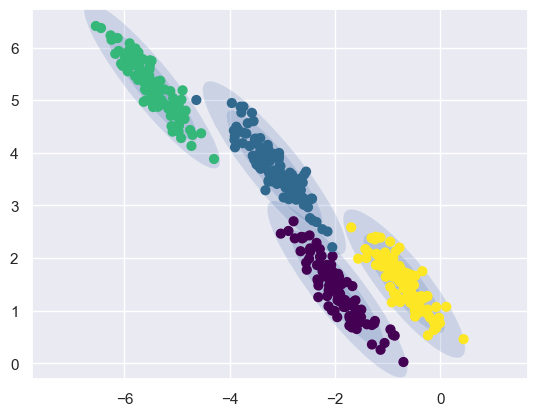

In [11]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

gmm = GMM(n_components=4,          # Create and fit a Gaussian Mixture Model (GMM) with 4 components
          covariance_type='full',  # Type of covariance matrix: 'full' means each component has its own general covariance matrix
          random_state=42)

# Fit the GMM to the stretched data and plot the result
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with k-means encountered before.

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

<left>
    <img src="images/05.12-covariance-type.png" width="1000" />
</left>

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function.

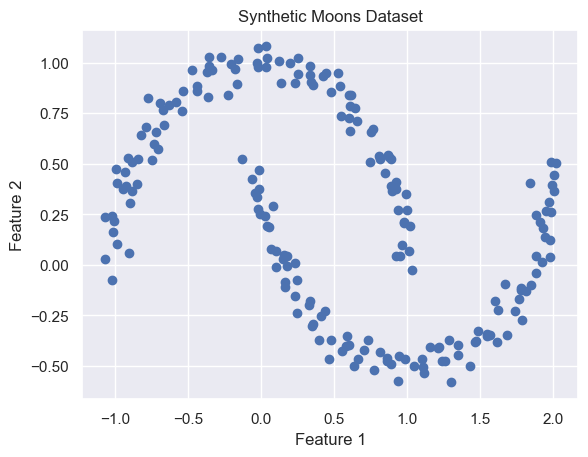

In [12]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt


# Generate a synthetic dataset of 200 samples with two interleaving half circles
Xmoon, ymoon = make_moons(200, 
                          noise=.05,      # 'noise=.05' adds some noise to make the dataset more realistic
                          random_state=0) # 'random_state=0' ensures reproducibility of the results

# Plot the generated dataset
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])
plt.xlabel('Feature 1')               # Optional: Label for the x-axis
plt.ylabel('Feature 2')               # Optional: Label for the y-axis
plt.title('Synthetic Moons Dataset')  # Optional: Title for the plot
plt.show()

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

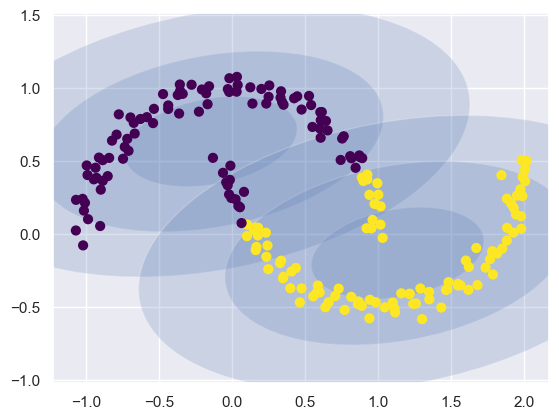

In [13]:
from sklearn.mixture import GaussianMixture as GMM

# Create a Gaussian Mixture Model (GMM) with 2 components and 'full' covariance type
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)

# Plot the GMM fitted to the moon dataset
plot_gmm(gmm2, Xmoon)

# Display the plot
plt.show()

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

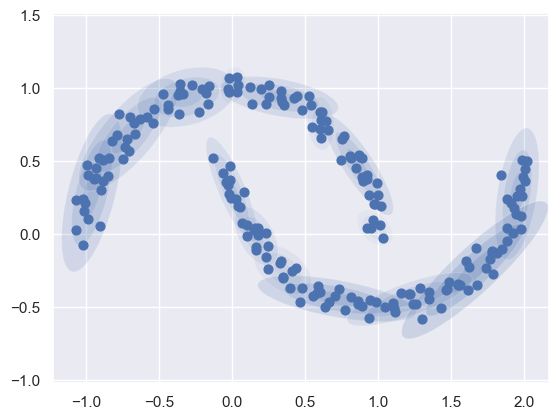

In [14]:
# Create a Gaussian Mixture Model (GMM) with 16 components and 'full' covariance type
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)

# Plot the GMM fitted to the moon dataset
# 'label=False' means that the data points will not be colored according to their cluster labels
plot_gmm(gmm16, Xmoon, label=False)

# Display the plot
plt.show()

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

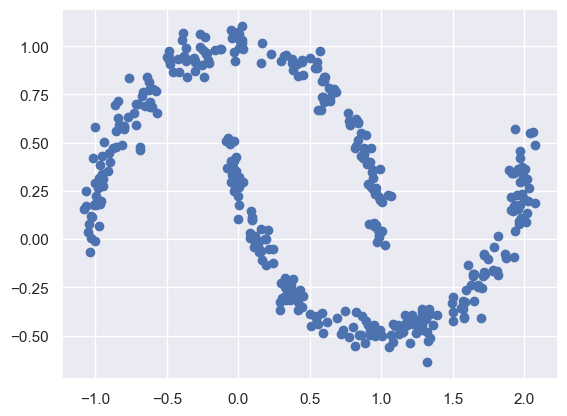

In [15]:
'''
The sample method from GaussianMixture returns a tuple where the first element is the generated samples 
and the second element is the cluster assignments. We need to extract the samples from this tuple before plotting.
'''

# Sample 400 new data points from the Gaussian Mixture Model (GMM)
Xnew, _ = gmm16.sample(400)    # Extract the samples

# Plot the new samples
plt.scatter(Xnew[:, 0], Xnew[:, 1])

# Display the plot
plt.show()

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

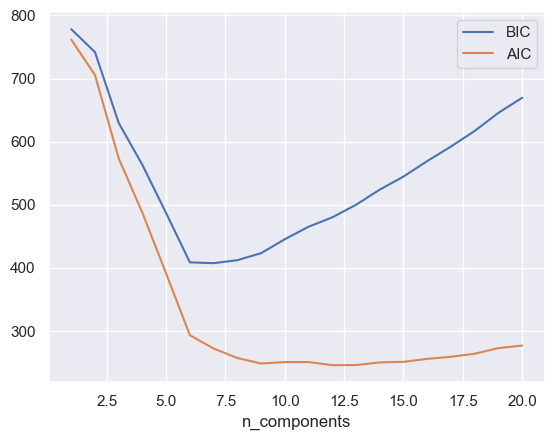

In [16]:
# Define the range of number of components to test
n_components = np.arange(1, 21)  # Number of Gaussian components to test, ranging from 1 to 20

# Fit Gaussian Mixture Models with varying number of components
# Create a list of GMM models, each with a different number of components
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]
# `models` contains GMM objects, each trained on `Xmoon` with a different number of components.

# Plot BIC (Bayesian Information Criterion) for each model
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
# Calculate BIC for each model and plot it against the number of components.
# BIC penalizes model complexity and can help to avoid overfitting.

# Plot AIC (Akaike Information Criterion) for each model
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
# Calculate AIC for each model and plot it against the number of components.
# AIC also penalizes complexity but is generally more lenient than BIC.

# Add a legend to differentiate between BIC and AIC lines
plt.legend(loc='best')

# Label the x-axis
plt.xlabel('n_components')
# This x-axis label indicates the number of Gaussian components used in the models.

# Display the plot
plt.show()

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [17]:
# Import the load_digits function from sklearn.datasets
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Check the shape of the data array
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

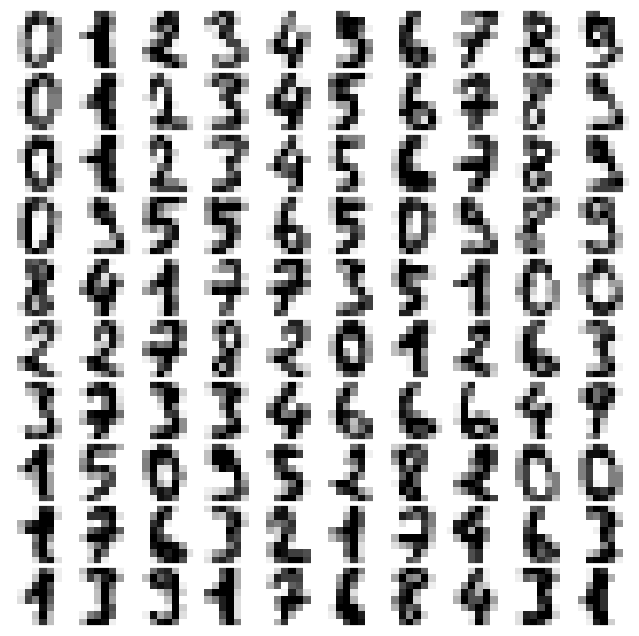

In [18]:
def plot_digits(data):
    
    # Create a figure and a 10x10 grid of subplots
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    
    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    # Iterate over each subplot and plot the corresponding digit image
    for i, axi in enumerate(ax.flat):
        
        # Reshape the data for the ith image (from 64 features to an 8x8 grid)
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        # Set the color limits for the display
        im.set_clim(0, 16)

# Call the function to plot the digits data
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more. GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data. Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [19]:
from sklearn.decomposition import PCA

# Initialize PCA with 99% variance retention and whitening
pca = PCA(0.99, whiten=True)

# Fit PCA on the digit data and transform the data
data = pca.fit_transform(digits.data)

# Print the shape of the transformed data
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss. Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

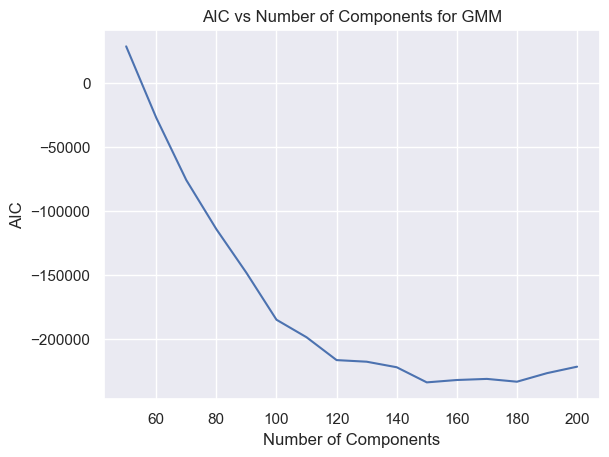

In [20]:
# Define a range of number of components for the Gaussian Mixture Model
n_components = np.arange(50, 210, 10)

# Create a list of Gaussian Mixture Models with varying number of components
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]

# Compute the Akaike Information Criterion (AIC) for each model
aics = [model.fit(data).aic(data) for model in models]

# Plot the AIC values against the number of components
plt.plot(n_components, aics)
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.title('AIC vs Number of Components for GMM')
plt.show()

It appears that around 150 components minimizes the AIC; we will use this model. Let's quickly fit this to the data and confirm that it has converged:

In [21]:
# Create a Gaussian Mixture Model with 150 components
gmm = GMM(150, covariance_type='full', random_state=0)

# Fit the GMM to the data
gmm.fit(data)

# Check if the model has converged
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [22]:
# Sample 100 new data points from the fitted Gaussian Mixture Model (GMM)
data_new, _ = gmm.sample(100)        # Extract the samples from the tuple

# Print the shape of the generated data
print(data_new.shape)

(100, 41)


Finally, we can use the inverse transform of the PCA object to construct the new digits:

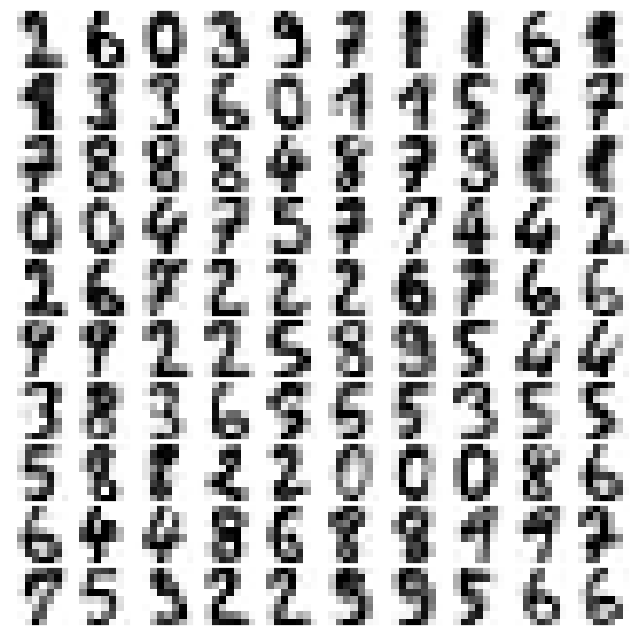

In [23]:
# Transform the new sampled data back to the original feature space
digits_new = pca.inverse_transform(data_new)

# Plot the transformed data as 8x8 digit images
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model. Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier, as we shall see in the next section.